### Paso 1: Segmentas SOLO las imagenes 1-9, sin las repetidas con modificaciones y guardarlas en una nueva carpeta

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image,ImageEnhance
import pandas as pd
import random

In [2]:
from os import scandir, getcwd

#Obtenemos la lista de las imágenes a redimensionar
def lsJPG(ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if (arch.is_file() and not arch.name.endswith('.2.jpg') 
                                                    and not arch.name.endswith('0.jpg') #no cargamos la img10
                                                    and arch.name.endswith('.jpg'))]

#Hay que poner doble \\ si hay un número despues de la barra
listImg = lsJPG("F:\Microplasticos\MuestrasPrueba (2,3,4-11-17)\Recortada\\2240x2240")
listImg

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg']

In [3]:
#Segmentamos las imagenes de nuevo
n = int(2240/64) #35
listaRegiones = []
for img in listImg:
    recort = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*64,j*64,i*64+64,j*64+64))
            subtring = img[0:-4]
            region.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+
                        "imgID"+subtring+"-R"+str(i)+"C"+str(j)+".jpg")
            listaRegiones.append("imgID"+subtring+"-R"+str(i)+"C"+str(j))

print(len(listaRegiones))

11025


 ### Paso 2: Cargar todos los CSV mapeados con el programa auxiliar de Java y concatenarlos

In [4]:
#Vamos a cargar todos los CSV creados por el Programa de Java para mapear las imágenes.
def lsCSV(ruta = getcwd()):
    return[arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.csv'))]

listCSV = lsCSV("F:\Microplasticos\MuestrasPrueba (2,3,4-11-17)\Recortada\\2240x2240\CSV Java")
listCSV = listCSV[:-1] #Quitamos el DatosTODOS.csv
listCSV

['DatosImg1.csv',
 'DatosImg2.csv',
 'DatosImg3.csv',
 'DatosImg4.csv',
 'DatosImg5.csv',
 'DatosImg6.csv',
 'DatosImg7.csv',
 'DatosImg8.csv',
 'DatosImg9.csv']

In [5]:
#Concatenamos todos los CSV y obtenemos el mapeado de todas las imagenes en un mismo dataframe
dfConcat = pd.read_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV Java/" + listCSV[0])
for i in listCSV[1:]:
    dfNew = pd.read_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV Java/" + i)
    dfConcat = pd.concat([dfConcat,dfNew],ignore_index=True)

dfConcat.count()

Nombre Segmento    11025
Plasticos          11025
dtype: int64

### Paso 3: Visualizar las diferencias de las distintas clases

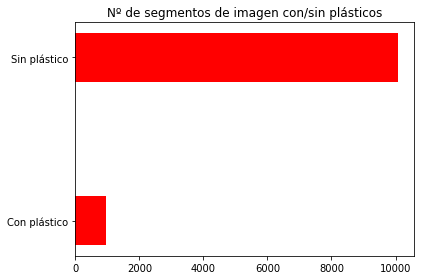

Imágenes a las que hay que hacer data augmentation:  949
Imágenes sin plasticos:  10076


In [14]:
def visualizarClases(dfConcat):
    #Contamos cuantos fragmentos tenemos con/sin plásticos
    unos = dfConcat[dfConcat['Plasticos'] == 1].count()
    ceros = dfConcat[dfConcat['Plasticos'] == 0].count()

    #Graficos de barras bonicos ---> https://plot.ly/matplotlib/bar-charts/
    plt.barh(["Con plástico","Sin plástico"],[unos.values[0],ceros.values[0]],color="red",height=0.3)
    plt.title("Nº de segmentos de imagen con/sin plásticos")
    plt.tight_layout() 
    plt.savefig("NSegmentosImg-64px.jpg", pad_inches=30)
    plt.show()
    print("Imágenes a las que hay que hacer data augmentation: ", unos[0])
    print("Imágenes sin plasticos: ", ceros[0])
    
visualizarClases(dfConcat)

Lista de nº de plasticos por img:  [26, 19, 226, 191, 95, 204, 116, 51, 21]


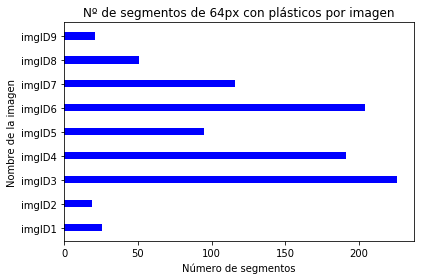

In [13]:
#Cantidad de unos por imagen
startName = ['imgID1','imgID2','imgID3','imgID4','imgID5','imgID6','imgID7','imgID8','imgID9']
imgInt = []
for i in startName:
    imgAux = dfConcat[dfConcat['Nombre Segmento'].str.startswith(i)]
    imgInt.append(imgAux[imgAux['Plasticos'] == 1].count()[0])

print("Lista de nº de plasticos por img: ", imgInt)    

#Grafico para ver la cantidad de pástico que hay por imagen
plt.barh(startName,imgInt, color="blue",height=0.3)
plt.title("Nº de segmentos de 64px con plásticos por imagen")
plt.xlabel('Número de segmentos')
plt.ylabel('Nombre de la imagen')

plt.tight_layout() 
plt.savefig("NSegmentosPorImg-64px.jpg")
plt.show()

### Paso 4: Hacer data augmentation de los segmentos con plástico

**Image.transpose(method)**<br/>
method – Possible values of method are:<br/>
PIL.Image.FLIP_LEFT_RIGHT<br/>
PIL.Image.FLIP_TOP_BOTTOM<br/>
PIL.Image.ROTATE_90<br/>
PIL.Image.ROTATE_180<br/>
PIL.Image.ROTATE_270<br/>
PIL.Image.TRANSPOSE or PIL.Image.TRANSVERSE.<br/>

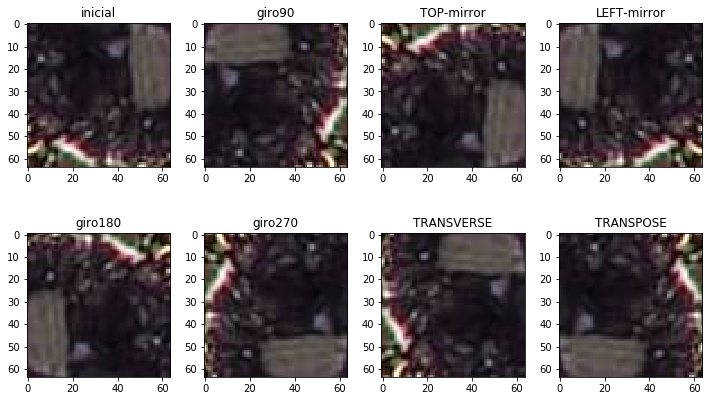

In [12]:
#Añadiremos al nombre de la imagen una A,B,C dependiendo de la rotación que se haga
#Necesitamos una lista con los nombres de las imagenes a modificar
listPlastico = dfConcat[dfConcat['Plasticos'] == 1]['Nombre Segmento'].tolist() #Hay que añadir el .jpg al final

imagenOriginal = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+listPlastico[1]+".jpg")
array = np.array(imagenOriginal)

imagen90 = imagenOriginal.transpose(Image.ROTATE_90)
array90 = np.array(imagen90)

imagenTOP = imagenOriginal.transpose(Image.FLIP_TOP_BOTTOM)
arrayTOP = np.array(imagenTOP)

imagenLEFT = imagenOriginal.transpose(Image.FLIP_LEFT_RIGHT)
arrayLEFT = np.array(imagenLEFT)

imagen180 = imagenOriginal.transpose(Image.ROTATE_180)
array180 = np.array(imagen180)

imagen270 = imagenOriginal.transpose(Image.ROTATE_270)
array270 = np.array(imagen270)

imagenTRANSVERSE = imagenOriginal.transpose(Image.TRANSVERSE)
arrayTRANSVERSE = np.array(imagenTRANSVERSE)

imagenTRANSPOSE = imagenOriginal.transpose(Image.TRANSPOSE)
arrayTRANSPOSE = np.array(imagenTRANSPOSE)

plt.figure(figsize=(10,6))

plt.subplot(241)
plt.title("inicial")
plt.imshow(array)

plt.subplot(242)
plt.title("giro90")
plt.imshow(array90)

plt.subplot(243)
plt.title("TOP-mirror")
plt.imshow(arrayTOP)

plt.subplot(244)
plt.title("LEFT-mirror")
plt.imshow(arrayLEFT)

plt.subplot(245)
plt.title("giro180")
plt.imshow(array180)

plt.subplot(246)
plt.title("giro270")
plt.imshow(array270)

plt.subplot(247)
plt.title("TRANSVERSE")
plt.imshow(arrayTRANSVERSE)

plt.subplot(248)
plt.title("TRANSPOSE")
plt.imshow(arrayTRANSPOSE)


plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
plt.tight_layout()
plt.savefig("DataAug-64px.jpg",  dpi = 300)
plt.show()

**Para buscar un caracter en una string:**<br/>
There are two string methods for this, find() and index(). The difference between the two is what happens when the search string isn't found. find() returns -1 and index() raises ValueError.<br/>
**Usando find():**<br/>
>myString = 'Position of a character'<br/>
>myString.find('s')<br/>
>2<br/>
>myString.find('x')<br/>
>-1 <br/>

**Usando index:**<br/>
> myString = 'Position of a character'<br/>
> myString.index('s')<br/>
> 2<br/>
> myString.index('x')<br/>
>ValueError: substring not found

https://stackoverflow.com/questions/2294493/how-to-get-the-position-of-a-character-in-python

In [15]:
#Bucles for para realizar el Data Augmentation
listNewImg = []
listPlastico = dfConcat[dfConcat['Plasticos'] == 1]['Nombre Segmento'].tolist() #Hay que añadir el .jpg al final
for i in listPlastico:
    imagenOriginal = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i+".jpg")

    imagen90 = imagenOriginal.transpose(Image.ROTATE_90)
    listNewImg.append(i[:5] +"a"+ i[5:])
    imagen90.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"a"+ i[5:]+".jpg")
    imagen180 = imagenOriginal.transpose(Image.ROTATE_180)
    listNewImg.append(i[:5] +"b"+ i[5:])
    imagen180.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"b"+ i[5:]+".jpg")
    imagen270 = imagenOriginal.transpose(Image.ROTATE_270)
    listNewImg.append(i[:5] +"c"+ i[5:])
    imagen270.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"c"+ i[5:]+".jpg")
    
    imagenTOPMirror = imagenOriginal.transpose(Image.FLIP_TOP_BOTTOM)
    listNewImg.append(i[:5] +"d"+ i[5:])
    imagenTOPMirror.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"d"+ i[5:]+".jpg")
    imagenLEFTMirror = imagenOriginal.transpose(Image.FLIP_LEFT_RIGHT)
    listNewImg.append(i[:5] +"e"+ i[5:])
    imagenLEFTMirror.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"e"+ i[5:]+".jpg")
    
    imagenTRANSVERSE = imagenOriginal.transpose(Image.TRANSVERSE)
    listNewImg.append(i[:5] +"f"+ i[5:])
    imagenTRANSVERSE.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"f"+ i[5:]+".jpg")
    imagenTRANSPOSE = imagenOriginal.transpose(Image.TRANSPOSE)
    listNewImg.append(i[:5] +"g"+ i[5:])
    imagenTRANSPOSE.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+i[:5] +"g"+ i[5:]+".jpg")

print(len(listNewImg))
    

6643


Enlace donde modifican la imágen con efectos: https://recursospython.com/guias-y-manuales/instalar-pil-pillow-efectos/

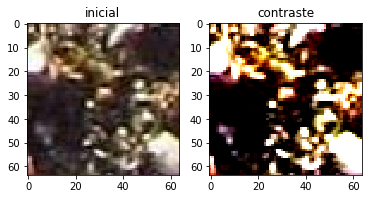

In [161]:
imagenOriginal = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+listPlastico[10]+".jpg")
array = np.array(imagenOriginal)

# Contraste.
new_image = ImageEnhance.Contrast(imagenOriginal).enhance(3)
array_new_image = np.array(new_image)

plt.figure()

plt.subplot(121)
plt.title("inicial")
plt.imshow(array)
plt.subplot(122)
plt.title("contraste")
plt.imshow(array_new_image)
plt.show()

**Pandas concat Vs append Vs join Vs merge:**
- **Concat** gives the flexibility to join based on the axis( all rows or all columns)
- **Append** is the specific case(axis=0, join='outer') of concat
- **Join** is based on the indexes (set by set_index) on how variable =['left','right','inner','couter']
- **Merge** is based on any particular column each of the two dataframes, this columns are variables on like 'left_on', 'right_on', 'on'

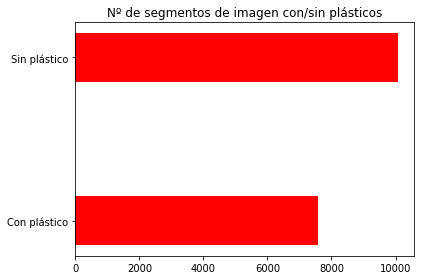

Imágenes a las que hay que hacer data augmentation:  7592
Imágenes sin plasticos:  10076


Nombre Segmento    17668
Plasticos          17668
dtype: int64

In [16]:
listNewImgUnos = np.ones(len(listNewImg),dtype=int)
dframe = pd.DataFrame({"Nombre Segmento":listNewImg, "Plasticos":listNewImgUnos}) 
dframe = pd.concat([dfConcat,dframe],ignore_index=True)

visualizarClases(dframe)
dframe.count()

In [220]:
#Guardamos el DataFrame con el data augmentation
dframe.to_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV Java/DatosImgTODOS.csv", header=True, index=False)

Como la diferencia entre clases sigue siendo bastante grande vamos a cortar de forma aleatoria los segmentos sin plastico hasta igualar a los de con plastico

In [182]:
unosList = dframe[dframe['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dframe[dframe['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))


#Mezclamos el orden de la lista para cortar las muestras de arena y así balancear las clases
print("\nComprobamos que los elementos están desordenados:")
print(cerosList[0:5])
random.shuffle(cerosList)
random.shuffle(unosList)
print(cerosList[0:5])

cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  7592
Imágenes sin plásticos:  10076

Comprobamos que los elementos están desordenados:
['imgID1-R0C0', 'imgID1-R0C1', 'imgID1-R0C2', 'imgID1-R0C3', 'imgID1-R0C4']
['imgID8-R1C14', 'imgID8-R13C26', 'imgID8-R33C21', 'imgID6-R1C17', 'imgID8-R34C0']
Ahora igualamos el nº de elementos: 
cerosList =  7592


In [183]:
nElementosTrain = int(len(cerosList)* 0.7)
print("Nº de elementos de cada lista para train ", nElementosTrain)

X_trainList = cerosList[:nElementosTrain] + unosList[:nElementosTrain]
random.shuffle(X_trainList)
print("Nº de elementos de X_train", len(X_trainList))

X_testList = cerosList[nElementosTrain:] + unosList[nElementosTrain:]
random.shuffle(X_testList)
print("Nº de elementos de X_test", len(X_testList))

Nº de elementos de cada lista para train  5314
Nº de elementos de X_train 10628
Nº de elementos de X_test 4556


In [186]:
#Preparamos los outputs para cada img
Y_train = []
for i in X_trainList:
    if i in cerosList : 
        Y_train.extend([0])
    else:
        Y_train.extend([1])

print(len(Y_train))

Y_test = []
for i in X_testList:
    if i in cerosList : 
        Y_test.extend([0])
    else:
        Y_test.extend([1])

print(len(Y_test))

10628
4556


### Paso 4.2: Separación de los datos para train y test

In [13]:
import random
from sklearn.model_selection import train_test_split

In [14]:
unosList = dframe[dframe['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dframe[dframe['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  7592
Imágenes sin plásticos:  10076
Ahora igualamos el nº de elementos: 
cerosList =  7592


In [15]:
x = unosList + cerosList
y = np.concatenate([np.ones((len(unosList),),dtype=int),np.zeros((len(cerosList),),dtype=int)])

# Con stratify=y nos aseguramos que se mantenga la proporción 50% 50%
X_trainList, X_testList, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, stratify=y)
print("xTrain: ", len(X_trainList), " xTest: ", len(X_testList))
print("yTrain: ", len(Y_train))
print(Y_train[0:50])
print("yTest : ", len(Y_test))
print(Y_test[0:50])
print("Como podemos observar los 0's y 1's están intercalados")

xTrain:  10628  xTest:  4556
yTrain:  10628
[1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0
 0 0 1 1 0 0 0 1 0 1 1 1 1]
yTest :  4556
[0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 1 1 1 1 1 0 0]
Como podemos observar los 0's y 1's están intercalados


In [18]:
#Comprobamos que está bien separado por proporciones
yTrainUnos, yTrainCeros, yTestUnos, yTestCeros = [0] * 4

for i in Y_train:
    if i == 0:
        yTrainCeros+=1
    else:
        yTrainUnos+=1

for i in Y_test:
    if i == 0:
        yTestCeros+=1
    else:
        yTestUnos+=1
        
print("valores de Train para cada conjunto = ",yTrainCeros,yTrainUnos)
print("valores de Test para cada conjunto =",yTestCeros,yTestUnos)

valores de Train para cada conjunto =  5314 5314
valores de Test para cada conjunto = 2278 2278


### Paso 5: Preparación y entrenamiento de la red neuronal básica

In [16]:
#Array con todas las imágenes a entrenar 
X_train = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+img + ".jpg")) for img in X_trainList] )
print(X_train.shape)
X_test = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+img + ".jpg")) for img in X_testList] )
print(X_test.shape)

(10628, 64, 64, 3)
(4556, 64, 64, 3)


In [17]:
#Normalizamos la imagen
X_train= X_train / 255.0
X_test= X_test / 255.0
print(X_train.shape)
print(X_test.shape)

(10628, 64, 64, 3)
(4556, 64, 64, 3)


In [17]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
model = Sequential()
model.add(Conv2D(16, (3, 3), input_shape=(64, 64,3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
model.add(Activation('relu'))

model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
#[metrics.mae, metrics.categorical_accuracy]

In [20]:
from keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png', show_shapes=True)

In [24]:
model_checkpoint = ModelCheckpoint('Segmentation64x64RedPesos.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[model_checkpoint])

Train on 10628 samples, validate on 4556 samples
Epoch 1/10
10628/10628 [==============================] - 73s 7ms/step - loss: 0.4505 - acc: 0.7822 - val_loss: 0.3358 - val_acc: 0.8486

Epoch 00001: val_loss improved from inf to 0.33581, saving model to Segmentation64x64RedPesos.hdf5
Epoch 2/10
10628/10628 [==============================] - 73s 7ms/step - loss: 0.2678 - acc: 0.9056 - val_loss: 0.2021 - val_acc: 0.9258

Epoch 00002: val_loss improved from 0.33581 to 0.20208, saving model to Segmentation64x64RedPesos.hdf5
Epoch 3/10
10628/10628 [==============================] - 75s 7ms/step - loss: 0.2310 - acc: 0.9190 - val_loss: 0.1923 - val_acc: 0.9317

Epoch 00003: val_loss improved from 0.20208 to 0.19227, saving model to Segmentation64x64RedPesos.hdf5
Epoch 4/10
10628/10628 [==============================] - 76s 7ms/step - loss: 0.2068 - acc: 0.9311 - val_loss: 0.1824 - val_acc: 0.9374

Epoch 00004: val_loss improved from 0.19227 to 0.18239, saving model to Segmentation64x64RedPe

In [25]:
#Cargamos los pesos del modelo
model.load_weights('Segmentation64x64RedPesos.hdf5')   

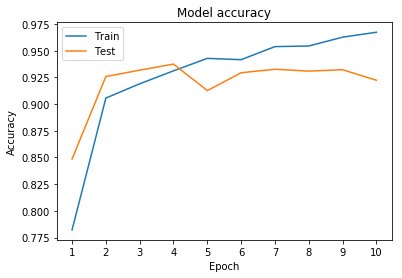

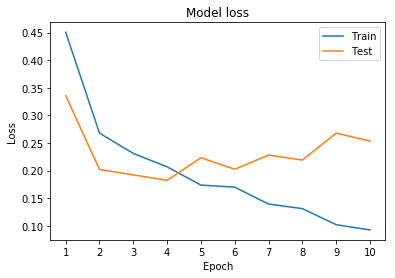

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(10), np.arange(1, 10+1))
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("GraficaAccuracy-64px.jpg")
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(10), np.arange(1, 10+1))
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("GraficaLoss-64px.jpg")
plt.show()

### Paso 5.2: Observación de los resultados obtenidos


In [193]:
print("---Evaluacion----")
ev = model.evaluate(X_test, Y_test, batch_size=32)
print(ev) #ev_loss - ev_acc

---Evaluacion----
4556/4556 [==============================] - 10s 2ms/step
[0.26177090968482059, 0.92449517120280944]


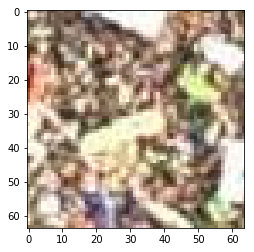

array([[ 0.99295241]], dtype=float32)

In [194]:
ejemplo = np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/imgID8-R20C15.jpg"))
plt.imshow(ejemplo)
plt.show()

prueba = ejemplo[np.newaxis,:]/255
#prueba.shape
model.predict(prueba)

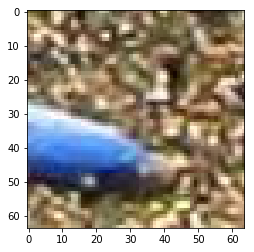

array([[ 1.]], dtype=float32)

In [195]:
ejemplo = np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/imgID1-R25C23.jpg"))
plt.imshow(ejemplo)
plt.show()

prueba = ejemplo[np.newaxis,:]/255
#prueba.shape
model.predict(prueba)

In [203]:
plasticos = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+img + ".jpg")) for img in unosList[nElementosTrain:]] )
print(plasticos.shape)

plasticos = plasticos/255
Y_plasticos = np.ones((len(plasticos),),dtype=int)

print("\n------Evaluación para imágenes con solo plastico conjunto test--------")
ev3 = model.evaluate(plasticos,Y_plasticos, batch_size=32)
print(ev3) #ev_loss - ev_acc

(2278, 64, 64, 3)

------Evaluación para imágenes con solo plastico conjunto test--------
2278/2278 [==============================] - 7s 3ms/step
[0.17524065416145995, 0.95566286215978924]


In [202]:
arena = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas - prueba 4/"+img + ".jpg")) for img in cerosList[nElementosTrain:]] )
print(arena.shape)

arena = arena/255
Y_arena= np.zeros((len(arena),),dtype=int)

print("\n------Evaluación para imágenes con arena conjunto test--------")
ev3 = model.evaluate(arena,Y_arena, batch_size=32)
print(ev3) #ev_loss - ev_acc

(2278, 64, 64, 3)

------Evaluación para imágenes con arena conjunto test--------
2278/2278 [==============================] - 7s 3ms/step
[0.34830116228747515, 0.89332748019349895]


### Paso 5.2: Visualización de resultados


In [39]:
from sklearn.metrics import confusion_matrix
pv =  np.ravel(model.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
conf_mat

array([[2139,  139],
       [ 146, 2132]], dtype=int64)

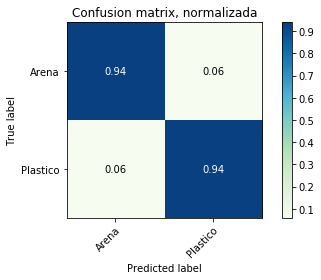

In [41]:
def matrixConfusion (conf_mat, cmap):
    
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]),
            yticks=np.arange(conf_mat.shape[0]),
            xticklabels=["Arena","Plastico"], yticklabels=["Arena","Plastico"],
            title='Confusion matrix, normalizada',
            ylabel='True label',
            xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("MatrizConfusion-64px.jpg")
    
    plt.show()
    
matrixConfusion(conf_mat,'GnBu')

### Paso 5.3: Visualizar predicciones

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from os import scandir, getcwd

In [45]:
def lsTestIMG(imgName, ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.jpg') 
                                                    and arch.name.startswith(imgName[0:-4]))] 
def segmentarImg(img):
    n = int(2240/64) #140
    listaRegionesTest = []
    recort = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/test/"+img)
    for i in range(0,n):
        for j in range(0,n):
            region = recort.crop((i*64,j*64,i*64+64,j*64+64))
            subtring = img[0:-4]
            region.save("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/TestImg Segmentadas64x64/"+
                        "imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
            listaRegionesTest.append("imgID-"+subtring+"-R"+"{0:0=2d}".format(i)+"C"+"{0:0=2d}".format(j)+".jpg")
    return listaRegionesTest
    
def evaluarVisualizarIMG(imagenPaVer):
    listNuevasPruebas = lsTestIMG("imgID-"+imagenPaVer,
                                  "F:\Microplasticos\MuestrasPrueba (2,3,4-11-17)\Recortada\\2240x2240\TestImg Segmentadas64x64")
    
    #Hay que segmentarla si no está segmentada o faltan segmentos
    if (not listNuevasPruebas) or (len(listNuevasPruebas)<140*140):
        listNuevasPruebas = segmentarImg(imagenPaVer)
        
    arrayNuevasPruebas = np.array([np.array(
                            Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/TestImg Segmentadas64x64/"+img)) 
                                   for img in listNuevasPruebas])
    arrayNuevasPruebas = arrayNuevasPruebas / 255.0

    evalNuevasPruebas =  np.ravel(model.predict(arrayNuevasPruebas))
    evalNuevasPruebas = np.asarray([int(round(i)) for i in evalNuevasPruebas])
    counterNuevasPruebas = np.count_nonzero(evalNuevasPruebas)
    n = int(2240/64) #140
            
    listVisual = np.asarray(listNuevasPruebas).reshape((n,n))
    evalVisual = evalNuevasPruebas.reshape((n, n))
    fondo = Image.new('RGBA', (2240, 2240), "black") 
    mask = Image.new('RGBA', (2240, 2240), "black") 
    blanco = Image.new('RGBA', (64, 64), "white")
    
    for i in range(0,n):
        for j in range(0,n):
            if evalVisual[i][j] == 1:
                imagen = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/TestImg Segmentadas64x64/"+listVisual[i][j])
                fondo.paste(imagen,(i*64,j*64))
                mask.paste(blanco,(i*64,j*64))
    
    fondo.save("%s_predict.png" %imagenPaVer[0:-4])
    mask.save("%s_mask.png"  %imagenPaVer[0:-4])  
    
    plt.figure(figsize=(15,15))
    plt.subplot(111)
    plt.axis('off')
    plt.title(imagenPaVer)
    array = np.array(fondo)
    plt.imshow(array)
    


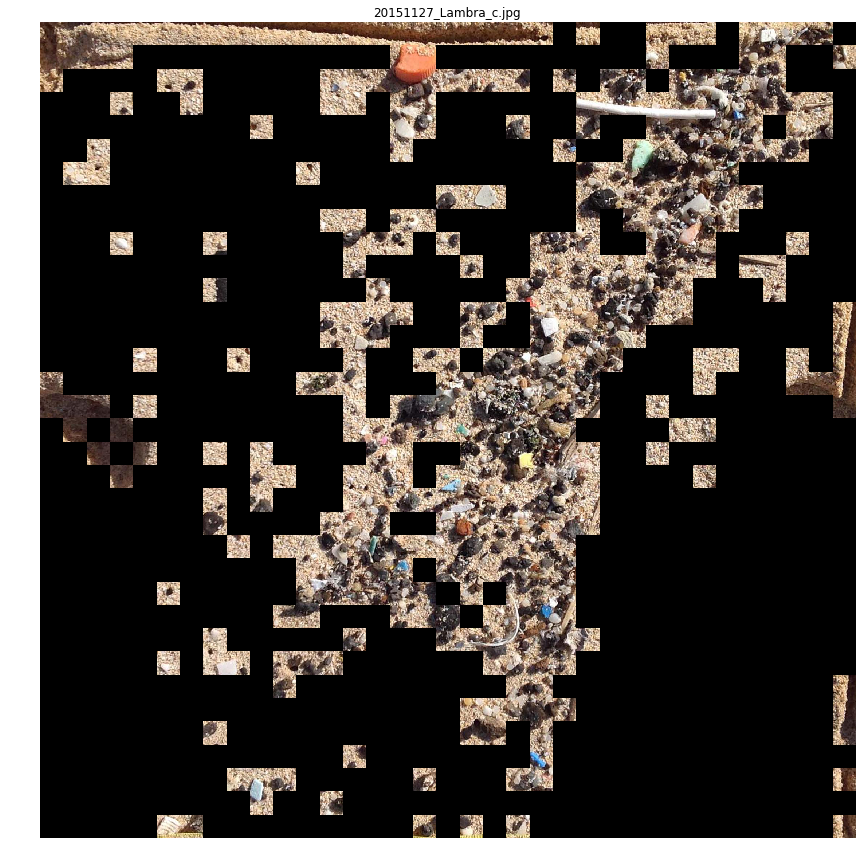

In [46]:
evaluarVisualizarIMG("20151127_Lambra_c.jpg")

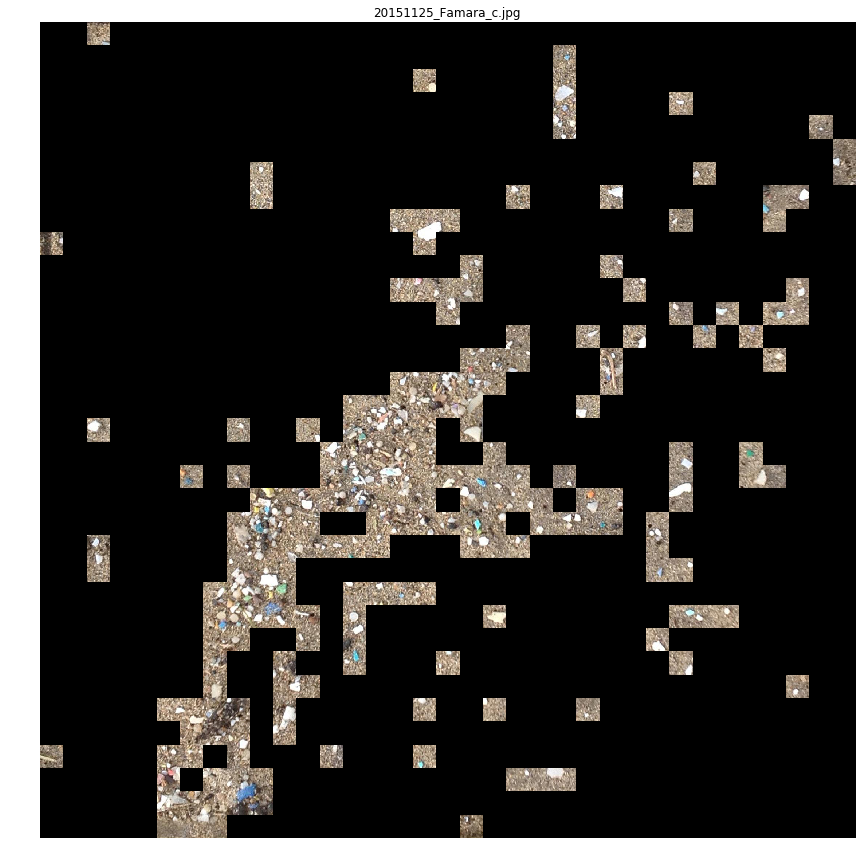

In [49]:
evaluarVisualizarIMG("20151125_Famara_c.jpg")

### Paso 6: Fine Tuning VGG16

In [204]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [209]:
#Importamos el modelo sin las capas de salida
vgg16_model = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [217]:
#No bloqueamos las capas para que los pesos inicializados con los de imagenet se entrenen
newModel = Sequential()
newModel.add(vgg16_model)

newModel.add(Flatten())
newModel.add(Dense(128, activation='relu'))
newModel.add(Dense(64, activation='relu'))
newModel.add(Dense(1, activation='sigmoid'))

newModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 14,985,281
Trainable params: 14,985,281
Non-trainable params: 0
_________________________________________________________________


In [218]:
newModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [ ]:
#newModel.fit(X_train, Y_train,  batch_size=32, epochs=10)
#TARDA DEMASIADO ----------- RIP -----> Pa' Google

### Paso 7:  Transfer learning VGG16

In [223]:
#Importamos el modelo sin las capas de salida
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg16_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [224]:
#Evitamos que se entrenen los pesos de las capas
for layer in vgg16_model2.layers:
    layer.trainable = False

In [225]:
#Bloqueamos las capas de input para que los pesos inicializados con los de imagenet se entrenen
newModel2 = Sequential()
newModel2.add(vgg16_model)

newModel2.add(Flatten())
newModel2.add(Dense(64, activation='relu'))
newModel2.add(Dense(1, activation='sigmoid'))

newModel2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                131136    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 14,845,889
Trainable params: 14,845,889
Non-trainable params: 0
_________________________________________________________________


In [226]:
newModel2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [228]:
#Al no tener que entrenar los pesos de las capas de VGG16, el entrenamiento debería ser mas rápido
newModel2.fit(X_train, Y_train,  batch_size=64, epochs=10)

Epoch 1/10
10628/10628 [==============================] - 4489s 422ms/step - loss: 7.9712 - acc: 0.5000
Epoch 2/10
10628/10628 [==============================] - 3610s 340ms/step - loss: 7.9712 - acc: 0.5000
Epoch 3/10
10628/10628 [==============================] - 3401s 320ms/step - loss: 7.9712 - acc: 0.5000
Epoch 4/10
10628/10628 [==============================] - 3405s 320ms/step - loss: 7.9712 - acc: 0.5000
Epoch 5/10
 3584/10628 [=========>....................] - ETA: 11:06:03 - loss: 7.9623 - acc: 0.5006

KeyboardInterrupt: 

### Paso 8: Comparación de resultados